In [60]:
# Alle Variablen löschen ohne zu fragen.
# Hierdurch werden Seiteneffekte vermieden.
%reset -f

In [1]:
# Voraussetzung: Mindestens tensorflow-Version 2
# mit integriertem Keras 

import tensorflow
print('Keras      :', tensorflow.keras.__version__)
print('Tensorflow :', tensorflow.__version__)

Keras      : 2.2.4-tf
Tensorflow : 2.1.0






# Multiclass-Klassifikation 
## Zweck
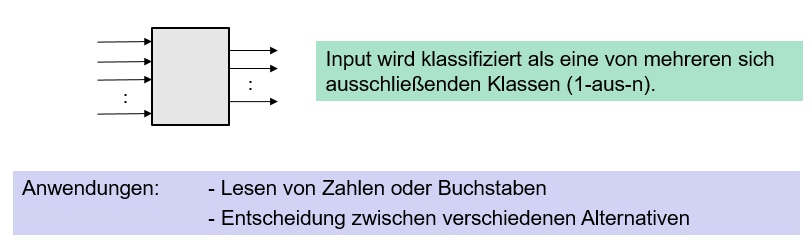

## Beispiel: Lesen handgeschriebener Zahlen 
### Idee
Im folgenden Beispiel sollen handgeschriebene Zahlen (Bildgröße 28x28) klassifiziert werden.
### Daten
Die Daten für das Training und die Validation des Klassifikators, stammen aus dem MNIST-Dataset.  
Die Daten sind wie folgt aufgeteilt: 60.000 Trainingsdaten und 10.000 Testdaten.  
Der MNIST-Datensatz ist im Keras-Paket enthalten.

---



# Es geht los ......
### Laden der benötigten Python-Bibliotheken
<ul>
<li><strong>numpy</strong>: Wissenschaftliches Rechnen mit Python
<li><strong>keras</strong>: Zusatz zu Tensorflow. Die Erstellung und das Training Neuronaler Netze wird dadurch erheblich vereinfacht.
<lu>

In [2]:
# Biliothek: Drucken von Grafiken, Bildern, etc. .....
from matplotlib            import pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

# Biliothek: Drucken von Grafiken, Bildern, etc. .....
from matplotlib            import pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

# Bibliothek: Rechnen mit Matrizen, Vektoren, etc. ......
import numpy as np

from tensorflow.keras.models          import Sequential
from tensorflow.keras.datasets        import mnist
from tensorflow.keras.layers          import Dense, Activation, Dropout, Flatten
from tensorflow.keras.layers          import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.utils           import model_to_dot, plot_model, to_categorical
from tensorflow.keras.optimizers      import RMSprop, SGD


### Reproduzierbare Versuche
Zufallszahlengenerator (z.B. bei der Initialisierung von NN) immer gleich starten (mit seed()).<br />
Versuche werden dadurch wiederholbar und vergleichbar.

In [3]:
np.random.seed(13)

### MNIST-Datensatz für Training und Test laden

In [4]:
(X_train_ori, y_train_ori), (X_test_ori, y_test_ori) = mnist.load_data()   # MNIST-Datensatz laden

NumClasses         = 10                    # Anzahl der Klassen (MNIST)
ImgRows, ImgCols   = 28, 28                # Format des Input-Fensters (MNIST)
InputSize          = ImgRows * ImgCols     # Größe des Input-Fensters (MNIST)

In [5]:
print('X_train_ori :', X_train_ori.shape)
print('X_test_ori  :', X_test_ori.shape)

X_train_ori : (60000, 28, 28)
X_test_ori  : (10000, 28, 28)


### Hilfsfunktionen

In [66]:
#  Funktionsdeklaration : Bilder in einem Raster Drucken
def draw_digit(data, row, col, n):
    plt.subplot(row, col, n)    
    plt.imshow(data)
    plt.gray()

# ============================================================

# Versuch 1: Multilayer-Perzeptron mit einem hidden Layer

### Formatierung der Trainings- und Testdaten für das Multilayer-Perzeptron
Multilayer-Perzeptron bekommt kein 28x28-Bild, sondern einfach nur 784 Inputwerte (= InputSize).

In [67]:
X_train = X_train_ori.reshape(60000, InputSize)
X_test  = X_test_ori.reshape( 10000, InputSize)

In [68]:
print('X_train :', X_train.shape)
print('X_test  :', X_test.shape)

X_train : (60000, 784)
X_test  : (10000, 784)


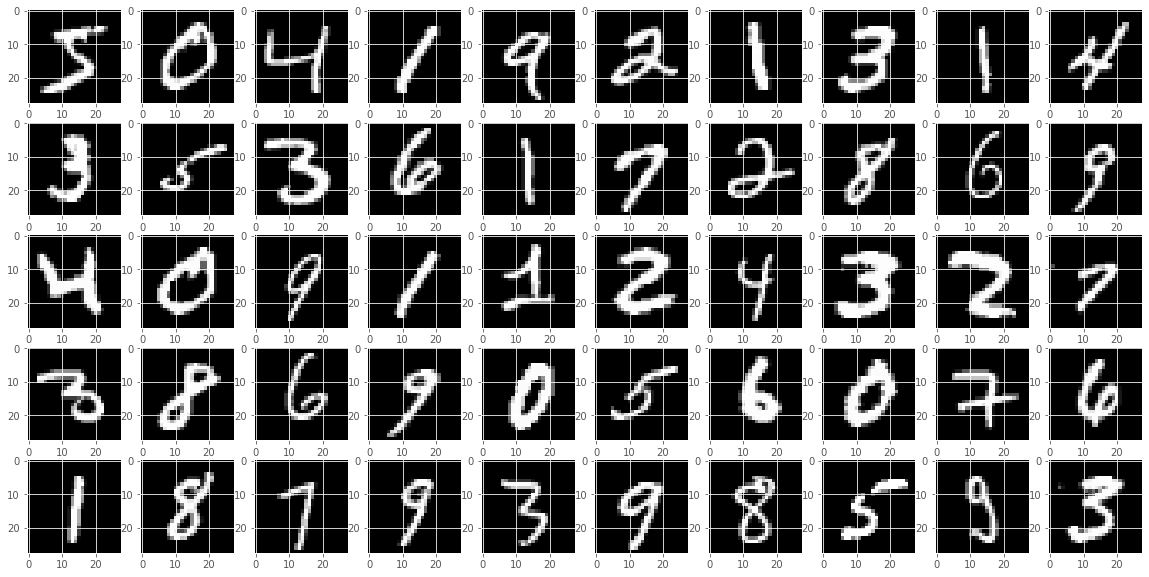

In [69]:
# Eine Auswahl von handgeschriebenen Zeichen in einem Bildraster anzeigen
cols                = 10
rows                = 5
plt.figure(figsize  = (20,10))

for i in range(rows):
    for k in range(cols):
        draw_digit(X_train[i*10+k].reshape(28,28), rows, cols, i*10+k+1)

plt.show()

### Grauwerte der Bilder für das NN aufbereiten

In [70]:
# Bildpunkttyp (Grauwerte = 0 ...255) auf float konvertieren ....
X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')

# ... und auf den Wertebereich 0...1 transformieren
X_train /= 255
X_test  /= 255

print('X_train :', X_train.shape)
print('X_test  :', X_test.shape)

X_train : (60000, 784)
X_test  : (10000, 784)


### Ergebnisse der Trainings- und Testdaten aufbereiten

Die Ergebnisse (Klassen der Bilder) liegen im Datensatz als Integerzahl vor (z.B. 7) wenn eine 7 abgebildet ist.<br />
Benötigt werden aber die Outputs des NN, also z.B. [0 0 0 0 0 0 0 1 0 0] für die abgebildete 7 (= One-hot-Encoding). 

Zu diesem Zweck müssen die Outputklassen konvertiert werden.

In [71]:
print(y_train_ori.shape)
print(y_train_ori[:5])

(60000,)
[5 0 4 1 9]


In [72]:
# Zahlenwert der Outputklasse konvertieren in 10-dim. Outputvektor transformieren (to_categorical-Methode)
Y_train = to_categorical(y_train_ori, 10)
Y_test  = to_categorical(y_test_ori,  10)

print(Y_train.shape)
print()
print(y_train_ori[:5])
print()
print(Y_train[:5])

(60000, 10)

[5 0 4 1 9]

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


### Beschreibung des gewünschten Neuronalen Netzes
Mit model.add() wird Schicht für Schicht des NN beschrieben.
<ul>
<li><strong>Dense</strong>: Einfacher Fully-connected-Layer.
<li><strong>sigmoid</strong>: Logistische Aktivierrungsfunktion (Alternativen: tanh, relu, selu, ....).
<li><strong>glorot_uniform</strong>: Methode zur zufälligen Gewichtsinitialisierung.
</ul>

Der letzte Layer ist als *softmax-Layer* ausgelegt. Die Summe der Ausgabewerte ist somit 1.

In [73]:
# ----------------------------------------------------
# Netz 1: Feed-forward-Netzwerk mit mehreren Layern
# ----------------------------------------------------


# ------------------------------------------------------------------------------------------
# Beschreibung des Netzes, Layer für Layer.
# ------------------------------------------------------------------------------------------
model = Sequential()


# 1. Hidden Layer:  Fully connected mit ReLu-Aktivierungsfunktion
model.add(Dense(units = 100,   kernel_initializer="glorot_uniform",   input_shape=(InputSize,)))
model.add(Activation("tanh"))

# weitere Möglichkeiten sind z.B. 
model.add(BatchNormalization())
model.add(Dropout(0.2))

# evtl. weitere Layer ......
model.add(Dense(units = 100,   kernel_initializer="glorot_uniform"))
model.add(Activation("relu"))

# Output Layer:  Fully connected mit Softmax-Aktivierungsfunktion
model.add(Dense(NumClasses,  kernel_initializer="glorot_uniform"))
model.add(Activation('softmax'))

# ------------------------------------------------------------------------------------------

In [74]:
# Übersicht über das NN und die Parameter
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 100)               78500     
_________________________________________________________________
activation_18 (Activation)   (None, 100)               0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 100)               400       
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 100)               10100     
_________________________________________________________________
activation_19 (Activation)   (None, 100)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 10)               

### Konfiguration des Lernprozesses
Gute Erklärungen zu den Parametern sind hier zu finden:  ([link](http://ruder.io/optimizing-gradient-descent/index.html#rmsprop))

In [75]:
model.compile(loss      = 'categorical_crossentropy',
              optimizer = 'adam',     # adam, rmsprop
              metrics   = ['accuracy'])

### Training des NN

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 6s 108us/sample - loss: 0.0593 - accuracy: 0.9804 - val_loss: 0.0812 - val_accuracy: 0.9788
Epoch 2/15
60000/60000 [==============================] - 6s 107us/sample - loss: 0.0588 - accuracy: 0.9807 - val_loss: 0.0809 - val_accuracy: 0.9788
Epoch 3/15
60000/60000 [==============================] - 7s 125us/sample - loss: 0.0545 - accuracy: 0.9812 - val_loss: 0.0811 - val_accuracy: 0.9790
Epoch 4/15
60000/60000 [==============================] - 5s 86us/sample - loss: 0.0515 - accuracy: 0.9822 - val_loss: 0.0752 - val_accuracy: 0.9798
Epoch 5/15
60000/60000 [==============================] - 5s 90us/sample - loss: 0.0494 - accuracy: 0.9830 - val_loss: 0.0808 - val_accuracy: 0.9791
Epoch 6/15
60000/60000 [==============================] - 5s 86us/sample - loss: 0.0478 - accuracy: 0.9840 - val_loss: 0.0757 - val_accuracy: 0.9809
Epoch 7/15
60000/60000 [=============================

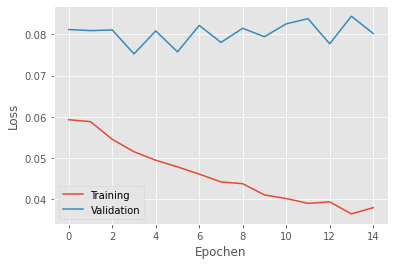

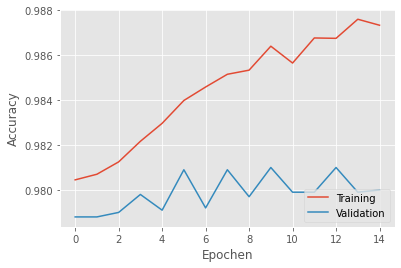

In [79]:
# Training
history = model.fit(X_train, Y_train,
                  batch_size      =  32,    # Minibatch-Größe
                  epochs          =  15,    # Anzahl der Trainingsepochen (ohne GPU nicht übertreiben)
                  verbose         =  1,     # Informationen anzeigen
                  validation_data =  (X_test, Y_test))


score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:    ', score[0])
print('Test accuracy:', score[1])
#plot
plt.figure(0)

plt.xlabel('Epochen')
plt.ylabel('Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])

plt.figure(1)
plt.xlabel('Epochen')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training', 'Validation'], loc='lower right')

plt.show()

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 13s 216us/sample - loss: 0.0683 - accuracy: 0.9776 - val_loss: 0.0893 - val_accuracy: 0.9786
Epoch 2/15
60000/60000 [==============================] - 12s 196us/sample - loss: 0.0616 - accuracy: 0.9802 - val_loss: 0.0848 - val_accuracy: 0.9801
Epoch 3/15
60000/60000 [==============================] - 12s 195us/sample - loss: 0.0610 - accuracy: 0.9805 - val_loss: 0.0834 - val_accuracy: 0.9786
Epoch 4/15
60000/60000 [==============================] - 12s 193us/sample - loss: 0.0602 - accuracy: 0.9804 - val_loss: 0.0780 - val_accuracy: 0.9804
Epoch 5/15
60000/60000 [==============================] - 12s 198us/sample - loss: 0.0565 - accuracy: 0.9807 - val_loss: 0.0775 - val_accuracy: 0.9804
Epoch 6/15
60000/60000 [==============================] - 13s 211us/sample - loss: 0.0580 - accuracy: 0.9816 - val_loss: 0.0802 - val_accuracy: 0.9791
Epoch 7/15
60000/60000 [====================

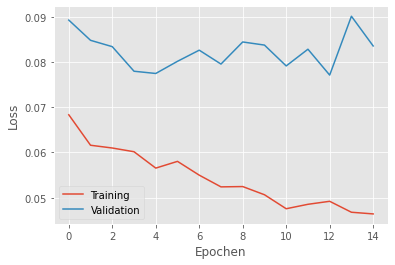

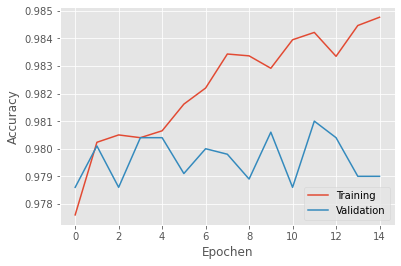

In [80]:
# Training
history = model.fit(X_train, Y_train,
                  batch_size      =  32,    # Minibatch-Größe
                  epochs          =  15,    # Anzahl der Trainingsepochen (ohne GPU nicht übertreiben)
                  verbose         =  1,     # Informationen anzeigen
                  validation_data =  (X_test, Y_test))


score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:    ', score[0])
print('Test accuracy:', score[1])
#plot
plt.figure(0)

plt.xlabel('Epochen')
plt.ylabel('Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])

plt.figure(1)
plt.xlabel('Epochen')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training', 'Validation'], loc='lower right')

plt.show()

Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 85s 1ms/sample - loss: 0.3993 - accuracy: 0.8740 - val_loss: 0.2925 - val_accuracy: 0.9613
Epoch 2/2
60000/60000 [==============================] - 83s 1ms/sample - loss: 0.2966 - accuracy: 0.9084 - val_loss: 0.3282 - val_accuracy: 0.9581
Test loss:     0.32821172623231826
Test accuracy: 0.9581


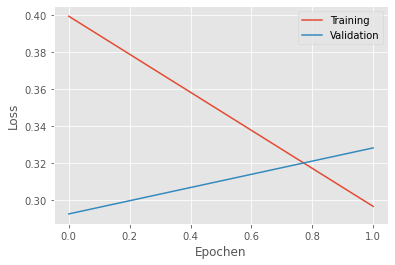

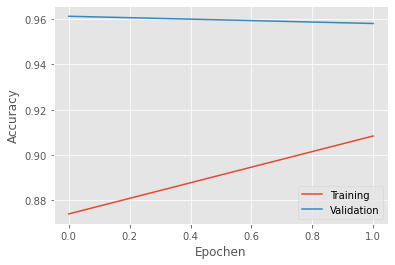

In [81]:
# Training
history = model.fit(X_train, Y_train,
                  batch_size      =  2,    # Minibatch-Größe
                  epochs          =  2,    # Anzahl der Trainingsepochen (ohne GPU nicht übertreiben)
                  verbose         =  1,     # Informationen anzeigen
                  validation_data =  (X_test, Y_test))


score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:    ', score[0])
print('Test accuracy:', score[1])
#plot
plt.figure(0)

plt.xlabel('Epochen')
plt.ylabel('Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])

plt.figure(1)
plt.xlabel('Epochen')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training', 'Validation'], loc='lower right')

plt.show()

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 89s 1ms/sample - loss: 0.2721 - accuracy: 0.9172 - val_loss: 0.3396 - val_accuracy: 0.9609
Epoch 2/5
60000/60000 [==============================] - 84s 1ms/sample - loss: 0.2498 - accuracy: 0.9239 - val_loss: 0.3347 - val_accuracy: 0.9617
Epoch 3/5
60000/60000 [==============================] - 84s 1ms/sample - loss: 0.2461 - accuracy: 0.9254 - val_loss: 0.3625 - val_accuracy: 0.9585
Epoch 4/5
60000/60000 [==============================] - 91s 2ms/sample - loss: 0.2336 - accuracy: 0.9283 - val_loss: 0.3480 - val_accuracy: 0.9622
Epoch 5/5
60000/60000 [==============================] - 89s 1ms/sample - loss: 0.2256 - accuracy: 0.9326 - val_loss: 0.3552 - val_accuracy: 0.9620
Test loss:     0.35523442257186655
Test accuracy: 0.962


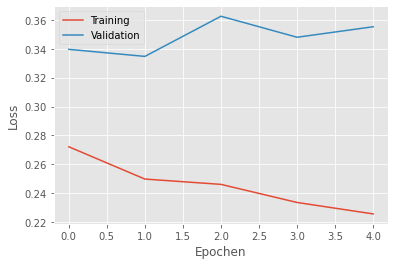

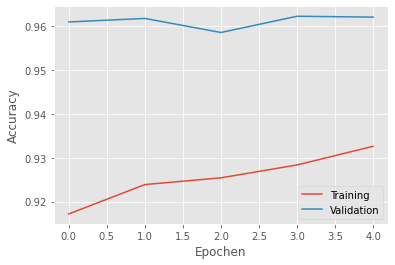

In [82]:
# Training
history = model.fit(X_train, Y_train,
                  batch_size      =  2,    # Minibatch-Größe
                  epochs          =  5,    # Anzahl der Trainingsepochen (ohne GPU nicht übertreiben)
                  verbose         =  1,     # Informationen anzeigen
                  validation_data =  (X_test, Y_test))


score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:    ', score[0])
print('Test accuracy:', score[1])
#plot
plt.figure(0)

plt.xlabel('Epochen')
plt.ylabel('Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])

plt.figure(1)
plt.xlabel('Epochen')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training', 'Validation'], loc='lower right')

plt.show()

Train on 60000 samples, validate on 10000 samples
Epoch 1/60
60000/60000 [==============================] - 5s 79us/sample - loss: 0.1888 - accuracy: 0.9650 - val_loss: 0.1802 - val_accuracy: 0.9692
Epoch 2/60
60000/60000 [==============================] - 3s 52us/sample - loss: 0.1376 - accuracy: 0.9711 - val_loss: 0.1568 - val_accuracy: 0.9713
Epoch 3/60
60000/60000 [==============================] - 3s 49us/sample - loss: 0.1101 - accuracy: 0.9738 - val_loss: 0.1398 - val_accuracy: 0.9731
Epoch 4/60
60000/60000 [==============================] - 4s 62us/sample - loss: 0.0949 - accuracy: 0.9764 - val_loss: 0.1238 - val_accuracy: 0.9737
Epoch 5/60
60000/60000 [==============================] - 3s 49us/sample - loss: 0.0799 - accuracy: 0.9774 - val_loss: 0.1161 - val_accuracy: 0.9742
Epoch 6/60
60000/60000 [==============================] - 3s 55us/sample - loss: 0.0710 - accuracy: 0.9790 - val_loss: 0.1042 - val_accuracy: 0.9752
Epoch 7/60
60000/60000 [==============================] 

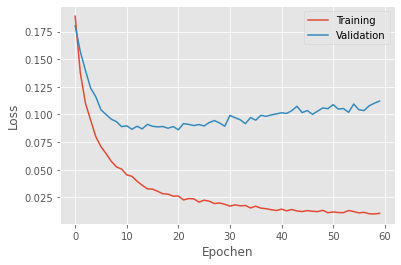

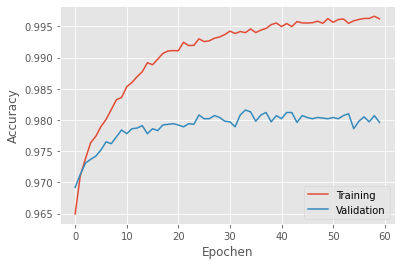

In [83]:
# Training
history = model.fit(X_train, Y_train,
                  batch_size      =  100,    # Minibatch-Größe
                  epochs          =  60,    # Anzahl der Trainingsepochen (ohne GPU nicht übertreiben)
                  verbose         =  1,     # Informationen anzeigen
                  validation_data =  (X_test, Y_test))


score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:    ', score[0])
print('Test accuracy:', score[1])
#plot
plt.figure(0)

plt.xlabel('Epochen')
plt.ylabel('Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])

plt.figure(1)
plt.xlabel('Epochen')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training', 'Validation'], loc='lower right')

plt.show()

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 3s 44us/sample - loss: 0.0060 - accuracy: 0.9979 - val_loss: 0.1152 - val_accuracy: 0.9824
Epoch 2/10
60000/60000 [==============================] - 2s 25us/sample - loss: 0.0053 - accuracy: 0.9982 - val_loss: 0.1164 - val_accuracy: 0.9821
Epoch 3/10
60000/60000 [==============================] - 1s 23us/sample - loss: 0.0050 - accuracy: 0.9982 - val_loss: 0.1146 - val_accuracy: 0.9816
Epoch 4/10
60000/60000 [==============================] - 2s 26us/sample - loss: 0.0045 - accuracy: 0.9984 - val_loss: 0.1169 - val_accuracy: 0.9812
Epoch 5/10
60000/60000 [==============================] - 2s 28us/sample - loss: 0.0045 - accuracy: 0.9986 - val_loss: 0.1196 - val_accuracy: 0.9816
Epoch 6/10
60000/60000 [==============================] - 2s 27us/sample - loss: 0.0047 - accuracy: 0.9984 - val_loss: 0.1167 - val_accuracy: 0.9818
Epoch 7/10
60000/60000 [==============================] 

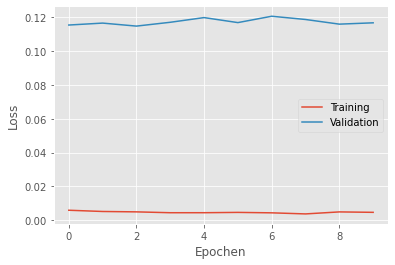

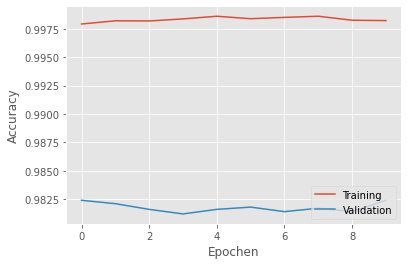

In [88]:
# Training
history = model.fit(X_train, Y_train,
                  batch_size      =  500,    # Minibatch-Größe
                  epochs          =  10,    # Anzahl der Trainingsepochen (ohne GPU nicht übertreiben)
                  verbose         =  1,     # Informationen anzeigen
                  validation_data =  (X_test, Y_test))


score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:    ', score[0])
print('Test accuracy:', score[1])
#plot
plt.figure(0)

plt.xlabel('Epochen')
plt.ylabel('Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])

plt.figure(1)
plt.xlabel('Epochen')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training', 'Validation'], loc='lower right')

plt.show()

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 1s 21us/sample - loss: 0.0041 - accuracy: 0.9986 - val_loss: 0.1174 - val_accuracy: 0.9819
Epoch 2/12
60000/60000 [==============================] - 1s 18us/sample - loss: 0.0040 - accuracy: 0.9986 - val_loss: 0.1173 - val_accuracy: 0.9814
Epoch 3/12
60000/60000 [==============================] - 1s 18us/sample - loss: 0.0035 - accuracy: 0.9989 - val_loss: 0.1186 - val_accuracy: 0.9817
Epoch 4/12
60000/60000 [==============================] - 1s 24us/sample - loss: 0.0047 - accuracy: 0.9986 - val_loss: 0.1238 - val_accuracy: 0.9820
Epoch 5/12
60000/60000 [==============================] - 1s 21us/sample - loss: 0.0046 - accuracy: 0.9985 - val_loss: 0.1208 - val_accuracy: 0.9821
Epoch 6/12
60000/60000 [==============================] - 1s 18us/sample - loss: 0.0040 - accuracy: 0.9987 - val_loss: 0.1187 - val_accuracy: 0.9820
Epoch 7/12
60000/60000 [==============================] 

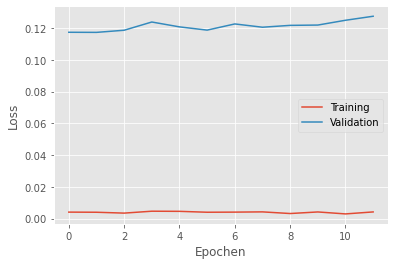

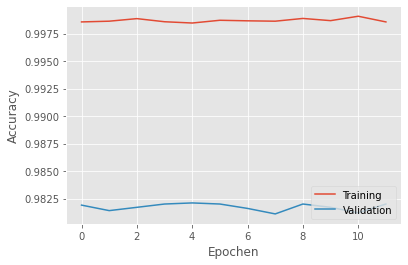

In [90]:
# Training
history = model.fit(X_train, Y_train,
                  batch_size      =  500,    # Minibatch-Größe
                  epochs          =  12,    # Anzahl der Trainingsepochen (ohne GPU nicht übertreiben)
                  verbose         =  1,     # Informationen anzeigen
                  validation_data =  (X_test, Y_test))


score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:    ', score[0])
print('Test accuracy:', score[1])
#plot
plt.figure(0)

plt.xlabel('Epochen')
plt.ylabel('Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])

plt.figure(1)
plt.xlabel('Epochen')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training', 'Validation'], loc='lower right')

plt.show()

============================================================================================================
# !!! Aufgaben

Modifizieren Sie das NN und das Training z.B. durch
* Layerzahl, 
* Neuronen pro Layer, 
* relu, selu, tanh, sigmoid
* adam, rmsprop
* Anzahl der Trainingsepochen, 
* Batchsize, usw. ... 

mit dem Ziel, eine Validation-Accuracy von mindestens 98.2% ** oder besser zu erreichen.  

### Dokumentieren
* die Parameter des NN und des Trainings 
* Val.-Accuracy 
* graph. Traingsverläufe 

============================================================================================================

### Fehleranalyse
1. Anzeigen einiger Fehlklassifikationen
2. Confusion-Matrix (= wer wird mit wem verwechselt?)

In [92]:
# Die erkannten Klassen der Testdaten bestimmen.
predicted_classes = model.predict_classes(X_test)

# Die Indices der richtig und falsch erkannten Muster bestimmen
correct   = np.nonzero(predicted_classes == y_test_ori)[0]     # nonzero:  Return the indices of array-
incorrect = np.nonzero(predicted_classes != y_test_ori)[0]     #           elements that are non-zero

<Figure size 432x288 with 0 Axes>

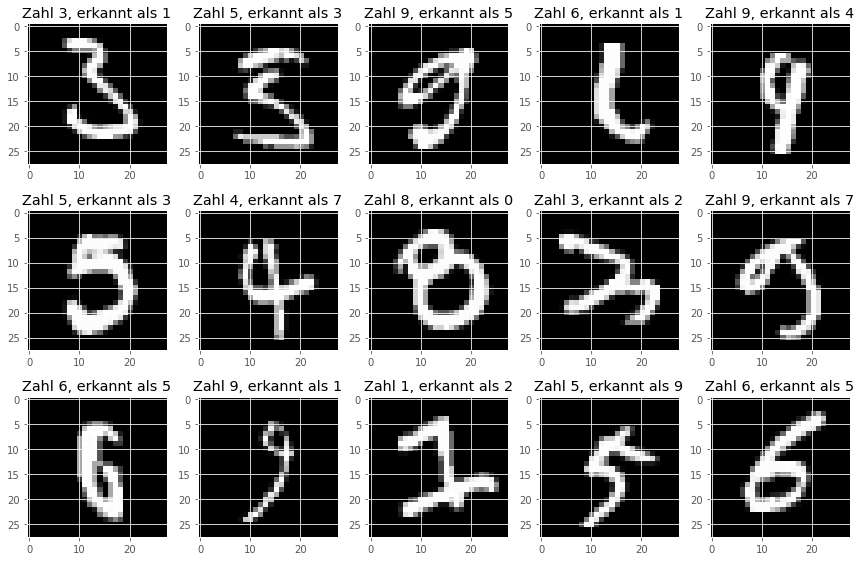

In [93]:
start                = 60    # Startindex

plt.figure(2)
plt.figure(figsize   = (12,8))
           
for i, incorr in enumerate(incorrect[start:start+15]):
    #print(i, incorr)
    plt.subplot(3,5,i+1)
    plt.imshow(X_test[incorr].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Zahl {}, erkannt als {}".format(y_test_ori[incorr], predicted_classes[incorr]))
    plt.tight_layout()

In [95]:
# Die Confusion-Matrix zeigt an, wie oft ein Zeichen
# für ein anderes Zeichen gehalten wird.
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test_ori, predicted_classes))

[[ 970    1    0    0    0    0    3    2    3    1]
 [   0 1130    1    0    0    1    2    1    0    0]
 [   4    3 1013    2    0    1    1    5    3    0]
 [   0    1    3  997    0    2    0    3    1    3]
 [   0    1    3    0  966    0    4    1    0    7]
 [   2    0    0   12    2  867    4    1    2    2]
 [   6    3    0    2    3    5  937    0    2    0]
 [   0    0    7    3    1    0    0 1010    0    7]
 [   5    2    2    5    2    6    1    5  942    4]
 [   1    4    0    4    9    2    0    1    0  988]]


# ==============================================================

# Versuch 2: Kleines Faltungsnetzwerk (CNN)

### Für Faltungsnetzwerke müssen die Bilddaten etwas anders aufbereitet werden (2-dimensional).

In [6]:
# Die Bilder sollen auf das Format 28x28x1 gebracht werden (28x28-Grauwertbild)

shape_ord = (ImgRows, ImgRows, 1)
    
print(shape_ord)
print(type(shape_ord))

(28, 28, 1)
<class 'tuple'>


In [7]:
# ....
X_train = X_train_ori.reshape((X_train.shape[0],) + shape_ord)
X_test  = X_test_ori.reshape((X_test.shape[0],)   + shape_ord)

# Bildpunkttyp auf float konvertieren ....
X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')

# ... und auf Wertebereich 0...1 transformieren
X_train /= 255
X_test  /= 255

print('X_train :', X_train.shape)
print('X_test  :', X_test.shape)

NameError: name 'X_train' is not defined

In [8]:
# ------------------------------------------------------------
# Netz 2: - Convolutional_NN mit 3 Conv-Layern + 2 Dense-Layern
#         - ReLu-Aktivierungsfunktion
#         - Dropout-Layer
# ------------------------------------------------------------

model = Sequential()

# -----------------------------------------------------------------------------------------
# Feature-Extractor
# -----------------------------------------------------------------------------------------
model.add(Conv2D(filters=32,      
                 kernel_size=(3, 3),   # alt kernel_size=(5, 5)
                 padding='valid', 
                 input_shape = shape_ord)) #(28, 28, 1)
model.add(Activation('relu'))
# 1Bild*32FM*(3*3)+32 = 320

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
#32inp.FM*64FM*(3*3)+64 = 18496


# weitere Möglichkeiten sind z.B. 
#model.add(BatchNormalization())
#model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=(3, 3)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
#64inp.FM*128FM*(3*3)+128 = 73856

    
model.add(Flatten())

# -----------------------------------------------------------------------------------------
# Classifier
# -----------------------------------------------------------------------------------------

model.add(Dense(units=128))
model.add(Activation('relu'))

model.add(Dropout(0.4))

#128*128+128 = 16512

model.add(Dense(units=10))
#128*10+10 = 1290


# Summe =110474
model.add(Activation('softmax'))

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
activation (Activation)      (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 11, 11, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 128)         7

In [120]:
# RW
#------------------------------------------------------------
# Netz 3: - Convolutional_NN mit 3 Conv-Layern + 2 Dense-Layern
#         - ReLu-Aktivierungsfunktion
#         - Dropout-Layer
# ------------------------------------------------------------

model = Sequential()

# -----------------------------------------------------------------------------------------
# Feature-Extractor
# -----------------------------------------------------------------------------------------
model.add(Conv2D(filters=32,      
                 #kernel_size=(3, 3),  
                 kernel_size=(5, 5),
                 padding='valid', 
                 input_shape = shape_ord)) #(28, 28, 1)
model.add(Activation('relu'))
# 1Bild*32FM*(3*3)+32 = 320

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3)))
model.add(Activation('relu'))

# model.add(MaxPooling2D(pool_size=(2, 2)))
#32inp.FM*64FM*(3*3)+64 = 18496


# weitere Möglichkeiten sind z.B. 
#model.add(BatchNormalization())
#model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=(3, 3)))
model.add(Activation('relu'))

#model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=256, kernel_size=(3, 3)))
model.add(Activation('relu'))

#model.add(MaxPooling2D(pool_size=(2, 2)))
#64inp.FM*128FM*(3*3)+128 = 73856

    
model.add(Flatten())

# -----------------------------------------------------------------------------------------
# Classifier
# -----------------------------------------------------------------------------------------

model.add(Dense(units=128))
model.add(Activation('relu'))

model.add(Dropout(0.4))

#128*128+128 = 16512

model.add(Dense(units=10))
#128*10+10 = 1290


# Summe =110474
model.add(Activation('softmax'))

# ??? Frage

Berechnen Sie händisch die Anzahl der zu trainierenden Parameter für das angegebene Faltungsnetzwerk 
und vergleichen Sie Ihr Ergebnis mit dem model.summary().

In [121]:
# Übersicht über das Faltungsnetzwerk und die Parameter
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 24, 24, 32)        832       
_________________________________________________________________
activation_64 (Activation)   (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 10, 10, 64)        18496     
_________________________________________________________________
activation_65 (Activation)   (None, 10, 10, 64)        0         
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 3, 3, 128)       

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 3s 58us/sample - loss: 0.0046 - accuracy: 0.9983 - val_loss: 0.1288 - val_accuracy: 0.9810
Epoch 2/10
60000/60000 [==============================] - 2s 31us/sample - loss: 0.0049 - accuracy: 0.9982 - val_loss: 0.1286 - val_accuracy: 0.9822
Epoch 3/10
60000/60000 [==============================] - 2s 27us/sample - loss: 0.0046 - accuracy: 0.9985 - val_loss: 0.1211 - val_accuracy: 0.9818
Epoch 4/10
60000/60000 [==============================] - 2s 28us/sample - loss: 0.0047 - accuracy: 0.9984 - val_loss: 0.1216 - val_accuracy: 0.9832
Epoch 5/10
60000/60000 [==============================] - 2s 27us/sample - loss: 0.0047 - accuracy: 0.9984 - val_loss: 0.1296 - val_accuracy: 0.9814
Epoch 6/10
60000/60000 [==============================] - 2s 28us/sample - loss: 0.0055 - accuracy: 0.9981 - val_loss: 0.1256 - val_accuracy: 0.9820
Epoch 7/10
60000/60000 [==============================] 

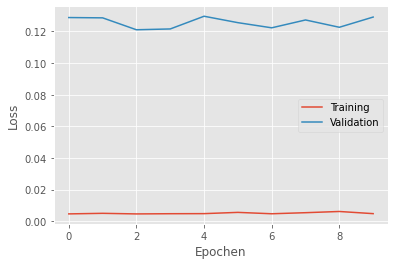

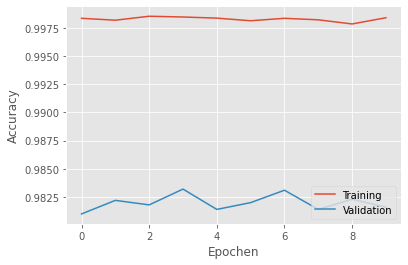

In [96]:
model.compile(loss     =  'categorical_crossentropy',
              optimizer=  'adam',
              metrics  =  ['accuracy'])



hist3 = model.fit(X_train, Y_train, 
                  batch_size = 32, 
                  epochs     = 10,   # ohne GPU nicht mehr als 4, sonst wartet man seeehr lange.
                  verbose    = 1,
                  validation_data=(X_test, Y_test))

print('Test loss:    ', score[0])
print('Test accuracy:', score[1])

#plot

plt.figure(6)
plt.xlabel('Epochen')
plt.ylabel('Loss')
plt.plot(hist3.history['loss'])
plt.plot(hist3.history['val_loss'])
plt.legend(['Training', 'Validation'])

plt.figure(7)
plt.xlabel('Epochen')
plt.ylabel('Accuracy')
plt.plot(hist3.history['accuracy'])
plt.plot(hist3.history['val_accuracy'])
plt.legend(['Training', 'Validation'], loc='lower right')

plt.show()

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 7s 117us/sample - loss: 0.0104 - accuracy: 0.9968 - val_loss: 0.1377 - val_accuracy: 0.9807
Epoch 2/10
60000/60000 [==============================] - 5s 75us/sample - loss: 0.0111 - accuracy: 0.9963 - val_loss: 0.1328 - val_accuracy: 0.9810
Epoch 3/10
60000/60000 [==============================] - 7s 120us/sample - loss: 0.0113 - accuracy: 0.9959 - val_loss: 0.1347 - val_accuracy: 0.9800
Epoch 4/10
60000/60000 [==============================] - 6s 106us/sample - loss: 0.0148 - accuracy: 0.9952 - val_loss: 0.1243 - val_accuracy: 0.9807
Epoch 5/10
60000/60000 [==============================] - 5s 82us/sample - loss: 0.0128 - accuracy: 0.9958 - val_loss: 0.1265 - val_accuracy: 0.9807
Epoch 6/10
60000/60000 [==============================] - 6s 103us/sample - loss: 0.0109 - accuracy: 0.9964 - val_loss: 0.1198 - val_accuracy: 0.9815
Epoch 7/10
60000/60000 [============================

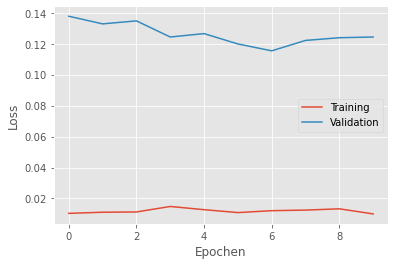

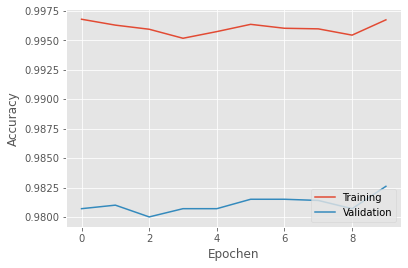

In [98]:
model.compile(loss     =  'categorical_crossentropy',
              optimizer=  'adam',
              metrics  =  ['accuracy'])



hist3 = model.fit(X_train, Y_train, 
                  batch_size = 50, 
                  epochs     = 10,   # ohne GPU nicht mehr als 4, sonst wartet man seeehr lange.
                  verbose    = 1,
                  validation_data=(X_test, Y_test))

print('Test loss:    ', score[0])
print('Test accuracy:', score[1])

#plot

plt.figure(6)
plt.xlabel('Epochen')
plt.ylabel('Loss')
plt.plot(hist3.history['loss'])
plt.plot(hist3.history['val_loss'])
plt.legend(['Training', 'Validation'])

plt.figure(7)
plt.xlabel('Epochen')
plt.ylabel('Accuracy')
plt.plot(hist3.history['accuracy'])
plt.plot(hist3.history['val_accuracy'])
plt.legend(['Training', 'Validation'], loc='lower right')

plt.show()

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 58s 972us/sample - loss: 0.2381 - accuracy: 0.9270 - val_loss: 0.7416 - val_accuracy: 0.9437
Epoch 2/10
60000/60000 [==============================] - 48s 807us/sample - loss: 0.0737 - accuracy: 0.9781 - val_loss: 0.0619 - val_accuracy: 0.9875
Epoch 3/10
60000/60000 [==============================] - 54s 894us/sample - loss: 0.0532 - accuracy: 0.9843 - val_loss: 0.0605 - val_accuracy: 0.9805
Epoch 4/10
60000/60000 [==============================] - 50s 835us/sample - loss: 0.0450 - accuracy: 0.9863 - val_loss: 0.0729 - val_accuracy: 0.9762
Epoch 5/10
60000/60000 [==============================] - 51s 855us/sample - loss: 0.0377 - accuracy: 0.9889 - val_loss: 0.0332 - val_accuracy: 0.9887
Epoch 6/10
60000/60000 [==============================] - 47s 777us/sample - loss: 0.0336 - accuracy: 0.9901 - val_loss: 0.0407 - val_accuracy: 0.9885
Epoch 7/10
60000/60000 [====================

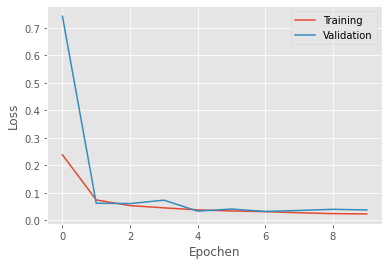

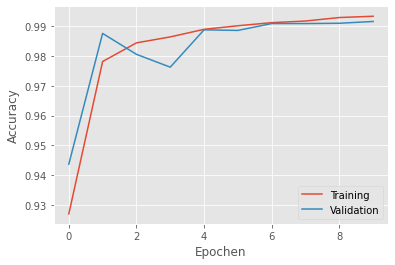

In [113]:
# weitere Möglichkeiten sind z.B. 
#model.add(BatchNormalization())
#model.add(Dropout(0.2))
model.compile(loss     =  'categorical_crossentropy',
              optimizer=  'rmsprop',
              metrics  =  ['accuracy'])



hist3 = model.fit(X_train, Y_train, 
                  batch_size = 256, 
                  epochs     = 10,   # ohne GPU nicht mehr als 4, sonst wartet man seeehr lange.
                  verbose    = 1,
                  validation_data=(X_test, Y_test))


#plot

plt.figure(6)
plt.xlabel('Epochen')
plt.ylabel('Loss')
plt.plot(hist3.history['loss'])
plt.plot(hist3.history['val_loss'])
plt.legend(['Training', 'Validation'])

plt.figure(7)
plt.xlabel('Epochen')
plt.ylabel('Accuracy')
plt.plot(hist3.history['accuracy'])
plt.plot(hist3.history['val_accuracy'])
plt.legend(['Training', 'Validation'], loc='lower right')

plt.show()

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 70s 1ms/sample - loss: 0.0338 - accuracy: 0.9904 - val_loss: 0.0399 - val_accuracy: 0.9878
Epoch 2/5
60000/60000 [==============================] - 74s 1ms/sample - loss: 0.0251 - accuracy: 0.9927 - val_loss: 0.0234 - val_accuracy: 0.9925
Epoch 3/5
60000/60000 [==============================] - 59s 982us/sample - loss: 0.0210 - accuracy: 0.9940 - val_loss: 0.0291 - val_accuracy: 0.9916
Epoch 4/5
60000/60000 [==============================] - 58s 962us/sample - loss: 0.0171 - accuracy: 0.9950 - val_loss: 0.0350 - val_accuracy: 0.9904
Epoch 5/5
60000/60000 [==============================] - 56s 940us/sample - loss: 0.0141 - accuracy: 0.9960 - val_loss: 0.0305 - val_accuracy: 0.9922


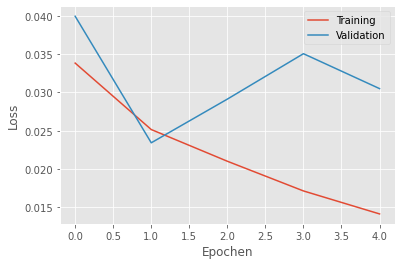

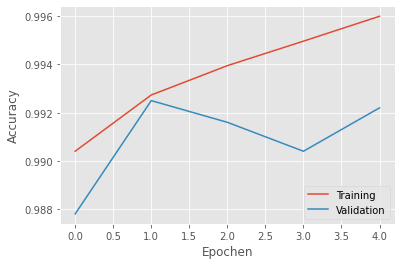

In [123]:
#256

model.compile(loss     =  'categorical_crossentropy',
              optimizer=  'rmsprop',
              metrics  =  ['accuracy'])



hist3 = model.fit(X_train, Y_train, 
                  batch_size = 256, 
                  epochs     = 5,   # ohne GPU nicht mehr als 4, sonst wartet man seeehr lange.
                  verbose    = 1,
                  validation_data=(X_test, Y_test))


#plot

plt.figure(6)
plt.xlabel('Epochen')
plt.ylabel('Loss')
plt.plot(hist3.history['loss'])
plt.plot(hist3.history['val_loss'])
plt.legend(['Training', 'Validation'])

plt.figure(7)
plt.xlabel('Epochen')
plt.ylabel('Accuracy')
plt.plot(hist3.history['accuracy'])
plt.plot(hist3.history['val_accuracy'])
plt.legend(['Training', 'Validation'], loc='lower right')

plt.show()

============================================================================================================
# !!! Aufgaben

Modifizieren Sie das NN und das Training z.B. durch
* Layerzahl,
* Kernel-Size,
* Neuronen (=filters) pro Layer, 
* relu, selu, tanh, sigmoid
* adam, rmsprop
* Anzahl der Trainingsepochen, 
* Batchsize, usw. ... 

mit dem Ziel, eine Validation-Accuracy von mind. 99.2% oder besser zu erreichen.  

### Dokumentieren
* die Parameter des NN und des Trainings 
* Val.-Accuracy 
* graph. Traingsverläufe 

============================================================================================================

### Fehleranalyse
1. Anzeigen einiger Fehlklassifikationen
2. Confusion-Matrix (= wer wird mit wem verwechselt?)

In [28]:
# Die erkannten Klassen der Testdaten bestimmen.
predicted_classes = model.predict_classes(X_test)

# Die Indices der richtig und falsch erkannten Muster bestimmen
correct   = np.nonzero(predicted_classes == y_test_ori)[0]     # nonzero:  Return the indices of array-
incorrect = np.nonzero(predicted_classes != y_test_ori)[0]     #           elements that are non-zero ()

In [29]:
predicted_classes

array([7, 2, 1, ..., 4, 5, 6], dtype=int64)

In [30]:
# predicted_classes[40:45]
# y_test_ori[40:45]
# np.nonzero(predicted_classes == y_test_ori)[0].shape
np.nonzero(predicted_classes != y_test_ori)[0].size

130

<Figure size 432x288 with 0 Axes>

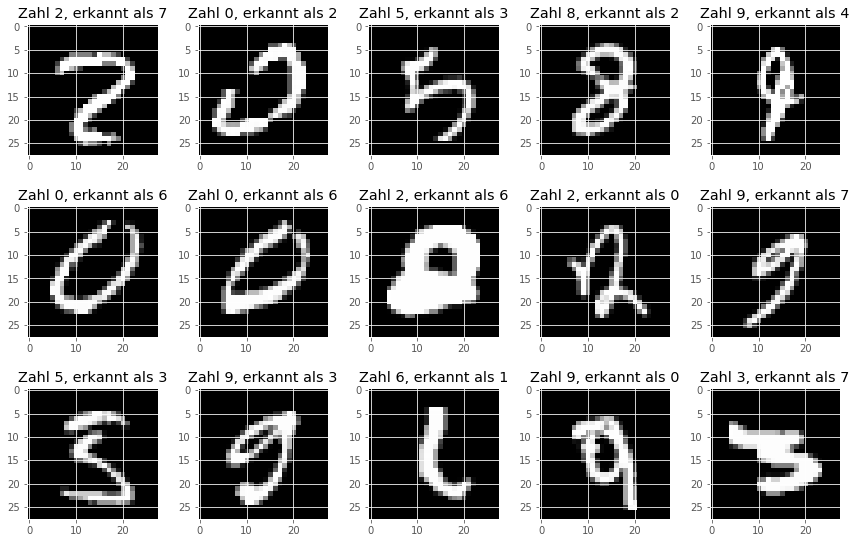

In [31]:
start                = 40    # Startindex

plt.figure(8)
plt.figure(figsize   = (12,8))
           
for i, incorr in enumerate(incorrect[start:start+15]):
    #print(i, incorr)
    plt.subplot(3,5,i+1)
    plt.imshow(X_test[incorr].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Zahl {}, erkannt als {}".format(y_test_ori[incorr], predicted_classes[incorr]))
    plt.tight_layout()

In [32]:
# Die Confusion-Matrix zeigt an, wie oft ein Zeichen
# für ein anderes Zeichen gehalten wird.
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test_ori, predicted_classes))

[[ 956    1    3    1    2    0    8    6    0    3]
 [   0 1126    0    2    0    0    3    4    0    0]
 [   1    0 1013    3    0    0    2   13    0    0]
 [   0    0    2 1004    0    1    0    3    0    0]
 [   0    0    2    0  975    0    1    1    0    3]
 [   0    0    1    7    0  879    4    1    0    0]
 [   0    2    1    0    3    1  951    0    0    0]
 [   0    1    4    0    0    1    0 1021    0    1]
 [   1    1    2    5    3    0    2    2  957    1]
 [   1    0    0    2    7    3    0    5    3  988]]
